Se detectaron 37 bursts


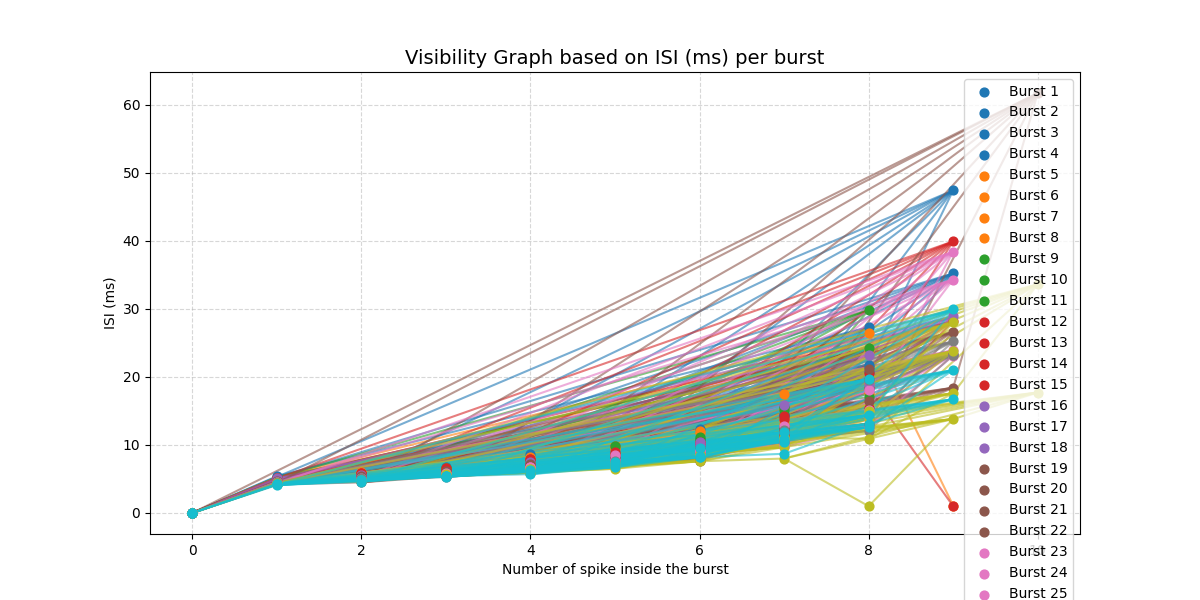

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pyabf
from scipy.signal import find_peaks
%matplotlib widget

# =========================
# 1. Cargar archivo ABF
# =========================
file_path_89 = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path_89)
abf.setSweep(15)

time = abf.sweepX      # eje tiempo
voltage = abf.sweepY   # señal
fs = abf.dataRate      # frecuencia de muestreo

# =========================
# 2. Detección de spikes
# =========================
threshold = -35  # mV
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]

# =========================
# 3. Detección de bursts (umbral ISI)
# =========================
isi = np.diff(spike_times)  # intervalos entre spikes
burst_threshold = 0.3       # en segundos (ej: 300 ms)

bursts = []
current_burst = [0]  # guardar índices de spikes
for i in range(1, len(spike_times)):
    if isi[i-1] < burst_threshold:
        current_burst.append(i)
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [i]
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Se detectaron {len(bursts)} bursts")

# =========================
# 4. Calcular ISI dentro de cada burst (ms)
# =========================
isi_per_spike_burst = np.zeros(len(spike_times))  # inicializamos

for burst in bursts:
    for i, idx in enumerate(burst):
        if i == 0:
            isi_per_spike_burst[idx] = 0  # primer spike = 0
        else:
            isi_per_spike_burst[idx] = (spike_times[idx] - spike_times[burst[i-1]]) * 1000  # ms

# =========================
# 5. Grafo de visibilidad basado en ISI
# =========================
plt.figure(figsize=(12,6))
colors = plt.cm.tab10(np.linspace(0,1,len(bursts)))

for b_idx, burst in enumerate(bursts):
    x_peaks = np.arange(len(burst))                    # número de spike dentro del burst
    y_peaks = isi_per_spike_burst[burst]              # ISI en ms

    # visibilidad entre spikes del mismo burst
    for a in range(len(x_peaks)):
        for b in range(a+1, len(x_peaks)):
            visible = True
            for c in range(a+1, b):
                y_line = y_peaks[b] + (y_peaks[a]-y_peaks[b])*(x_peaks[b]-x_peaks[c])/(x_peaks[b]-x_peaks[a])
                if y_peaks[c] >= y_line:
                    visible = False
                    break
            if visible:
                plt.plot([x_peaks[a], x_peaks[b]],
                         [y_peaks[a], y_peaks[b]],
                         color=colors[b_idx], alpha=0.6)

    # nodos de ese burst
    plt.scatter(x_peaks, y_peaks, color=colors[b_idx], s=40, zorder=5, label=f"Burst {b_idx+1}")

# =========================
# 6. Etiquetas y mostrar
# =========================
plt.title("Visibility Graph based on ISI (ms) per burst", fontsize=14)
plt.xlabel("Number of spike inside the burst")
plt.ylabel("ISI (ms)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

Se detectaron 5 bursts


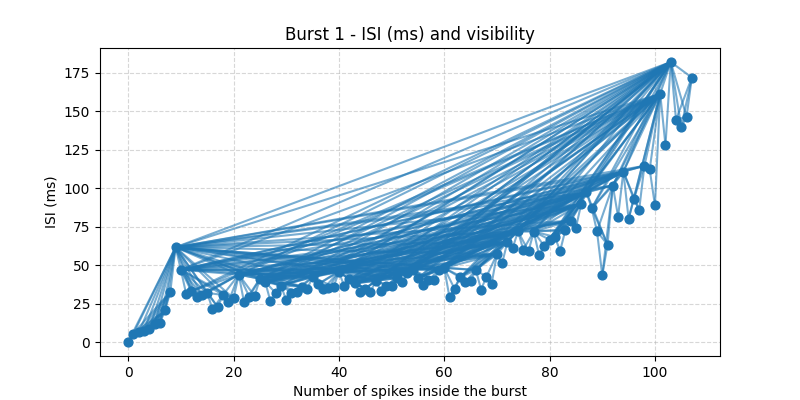

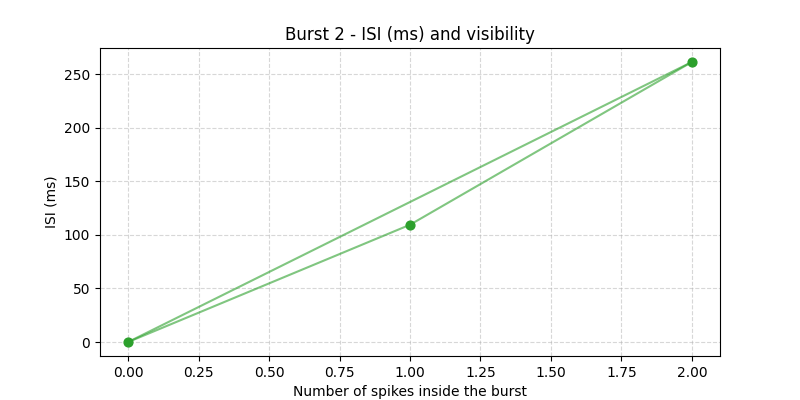

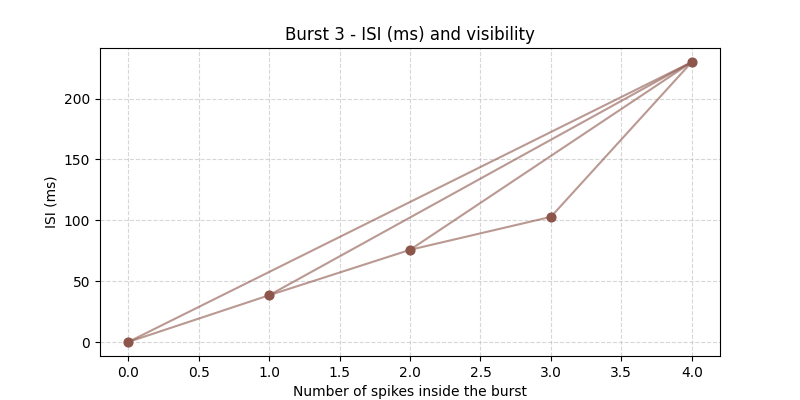

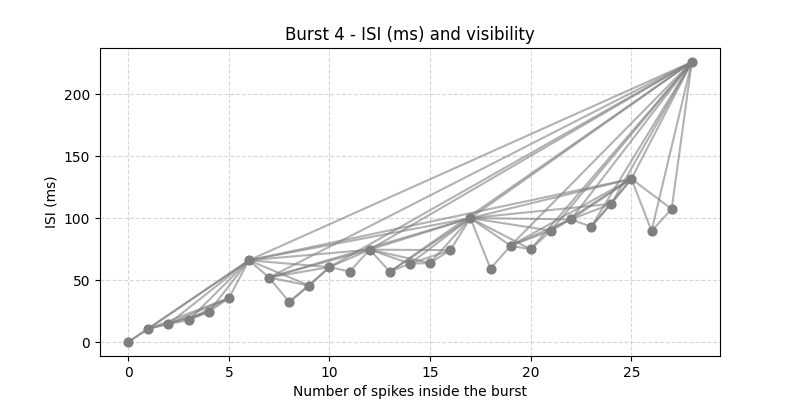

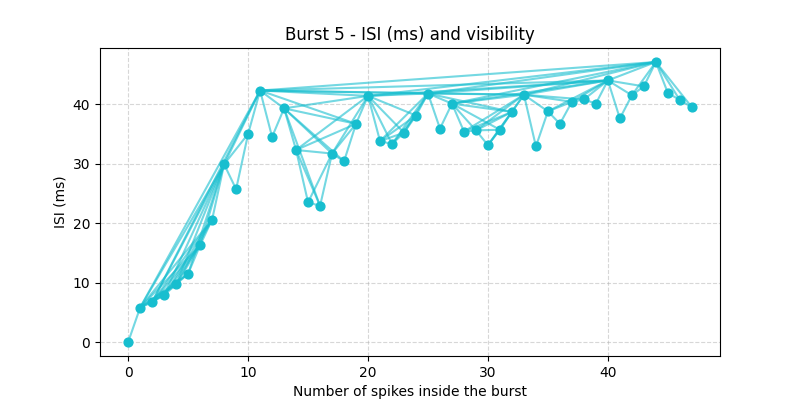

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pyabf
from scipy.signal import find_peaks
%matplotlib widget

# =========================
# 1. Cargar archivo ABF
# =========================
file_path_89 = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path_89)
abf.setSweep(1)

time = abf.sweepX      # eje tiempo
voltage = abf.sweepY   # señal

# =========================
# 2. Detección de spikes
# =========================
threshold = -35  # mV
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]

# =========================
# 3. Detección de bursts (umbral ISI)
# =========================
isi = np.diff(spike_times)  # intervalos entre spikes
burst_threshold = 0.3       # en segundos

bursts = []
current_burst = [0]  # guardar índices de spikes
for i in range(1, len(spike_times)):
    if isi[i-1] < burst_threshold:
        current_burst.append(i)
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [i]
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Se detectaron {len(bursts)} bursts")

# =========================
# 4. Calcular ISI interno de cada burst (ms)
# =========================
isi_per_spike_burst = np.zeros(len(spike_times))  # inicializamos

for burst in bursts:
    for i, idx in enumerate(burst):
        if i == 0:
            isi_per_spike_burst[idx] = 0  # primer spike = 0
        else:
            isi_per_spike_burst[idx] = (spike_times[idx] - spike_times[burst[i-1]]) * 1000  # ms

# =========================
# 5. Graficar cada burst por separado
# =========================
colors = plt.cm.tab10(np.linspace(0,1,len(bursts)))

for b_idx, burst in enumerate(bursts):
    x_peaks = np.arange(len(burst))                  # número de spike dentro del burst
    y_peaks = isi_per_spike_burst[burst]            # ISI en ms

    plt.figure(figsize=(8,4))
    
    # Grafo de visibilidad dentro del burst
    for a in range(len(x_peaks)):
        for b in range(a+1, len(x_peaks)):
            visible = True
            for c in range(a+1, b):
                y_line = y_peaks[b] + (y_peaks[a]-y_peaks[b])*(x_peaks[b]-x_peaks[c])/(x_peaks[b]-x_peaks[a])
                if y_peaks[c] >= y_line:
                    visible = False
                    break
            if visible:
                plt.plot([x_peaks[a], x_peaks[b]],
                         [y_peaks[a], y_peaks[b]],
                         color=colors[b_idx], alpha=0.6)

    # Nodos del burst
    plt.scatter(x_peaks, y_peaks, color=colors[b_idx], s=40, zorder=5)
    plt.title(f"Burst {b_idx+1} - ISI (ms) and visibility")
    plt.xlabel("Number of spikes inside the burst")
    plt.ylabel("ISI (ms)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

Se detectaron 3 bursts


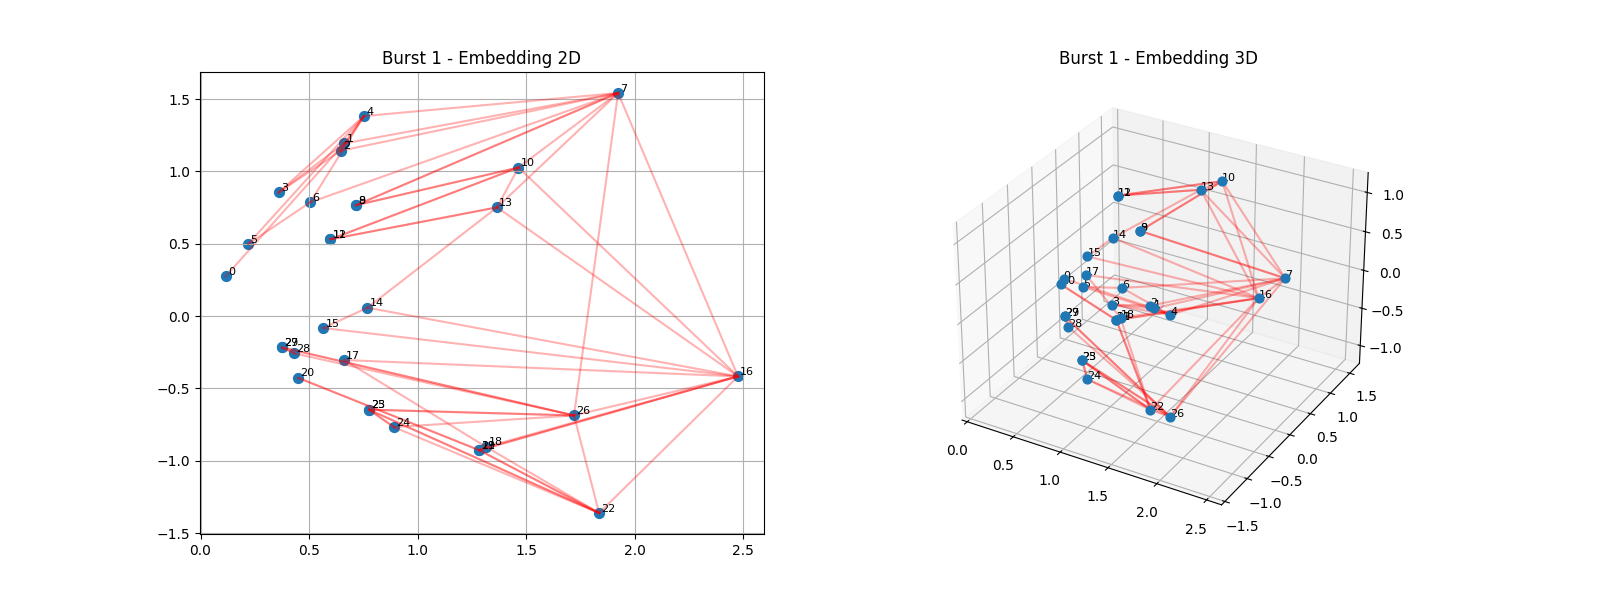

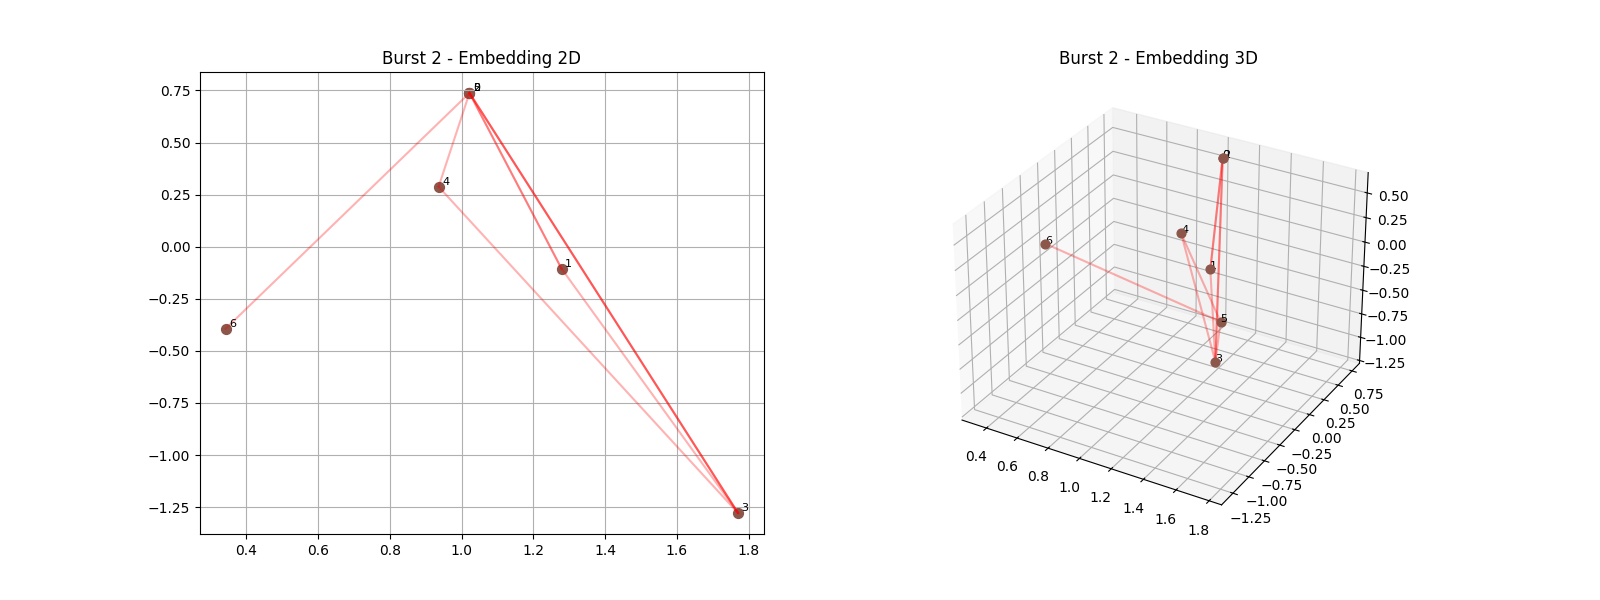

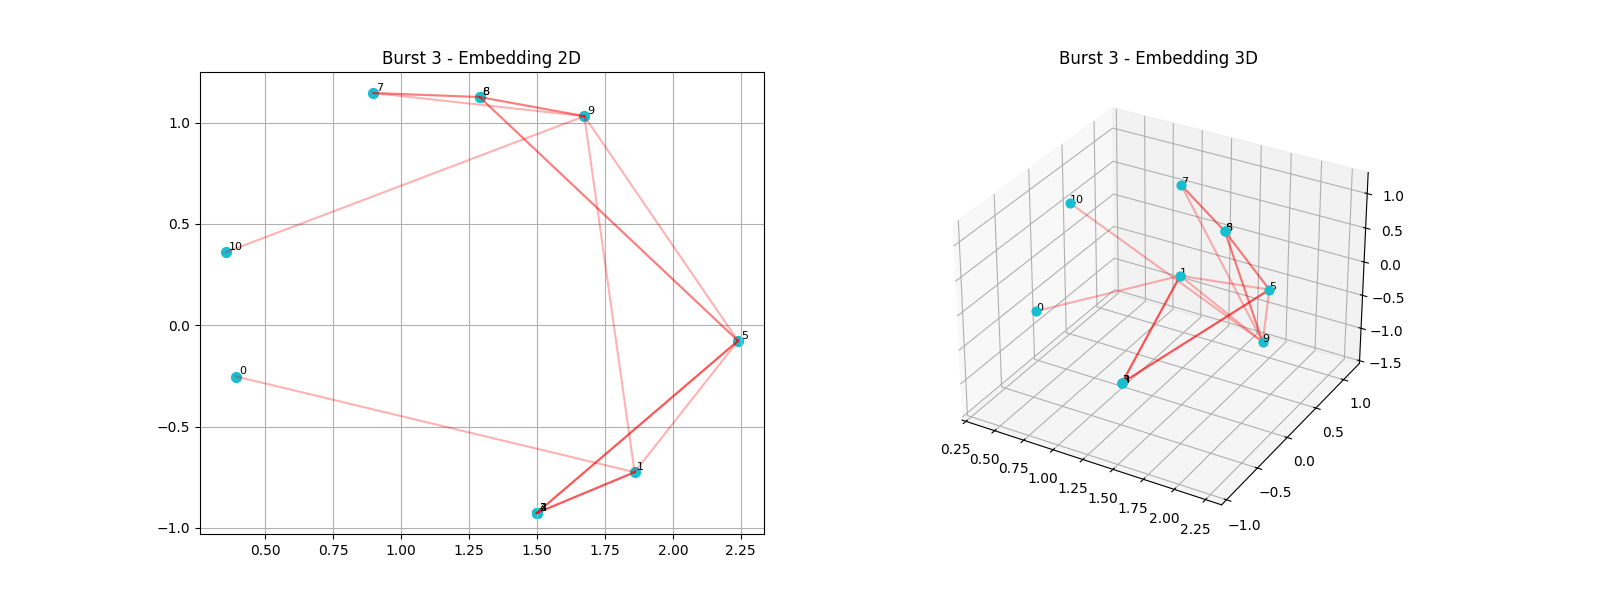

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pyabf
import networkx as nx
from scipy.signal import find_peaks
from sklearn.decomposition import TruncatedSVD
from mpl_toolkits.mplot3d import Axes3D

# =========================
# 1. Cargar archivo ABF
# =========================
file_path = "bursting/cell91basal.abf"
abf = pyabf.ABF(file_path)
abf.setSweep(4)

time = abf.sweepX
voltage = abf.sweepY

# =========================
# 2. Detección de spikes
# =========================
threshold = -35  # mV
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]

# =========================
# 3. Detección de bursts
# =========================
isi = np.diff(spike_times)
burst_threshold = 0.3  # s

bursts = []
current_burst = [0]
for i in range(1, len(spike_times)):
    if isi[i-1] < burst_threshold:
        current_burst.append(i)
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [i]
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Se detectaron {len(bursts)} bursts")

# =========================
# 4. Calcular ISI interno de cada burst (ms)
# =========================
isi_per_spike_burst = np.zeros(len(spike_times))
for burst in bursts:
    for i, idx in enumerate(burst):
        if i == 0:
            isi_per_spike_burst[idx] = 0
        else:
            isi_per_spike_burst[idx] = (spike_times[idx] - spike_times[burst[i-1]]) * 1000

# =========================
# 5. Crear grafos de visibilidad y calcular embeddings
# =========================
colors = plt.cm.tab10(np.linspace(0,1,len(bursts)))

for b_idx, burst in enumerate(bursts):
    x_peaks = np.arange(len(burst))
    y_peaks = isi_per_spike_burst[burst]

    # --- Grafo de visibilidad ---
    G = nx.Graph()
    G.add_nodes_from(range(len(burst)))

    for a in range(len(x_peaks)):
        for b in range(a+1, len(x_peaks)):
            visible = True
            for c in range(a+1, b):
                y_line = y_peaks[b] + (y_peaks[a]-y_peaks[b])*(x_peaks[b]-x_peaks[c])/(x_peaks[b]-x_peaks[a])
                if y_peaks[c] >= y_line:
                    visible = False
                    break
            if visible:
                G.add_edge(a, b)

    # --- Matriz de adyacencia ---
    A = nx.to_numpy_array(G)

    # --- Embedding 2D ---
    svd2 = TruncatedSVD(n_components=2, random_state=42)
    embedding_2d = svd2.fit_transform(A)

    # --- Embedding 3D ---
    svd3 = TruncatedSVD(n_components=3, random_state=42)
    embedding_3d = svd3.fit_transform(A)

    # --- Graficar embeddings ---
    fig = plt.figure(figsize=(16,6))

    # 2D
    ax2 = fig.add_subplot(1, 2, 1)
    for i in range(len(burst)):
        ax2.scatter(embedding_2d[i,0], embedding_2d[i,1], s=50, color=colors[b_idx])
        ax2.text(embedding_2d[i,0]+0.01, embedding_2d[i,1]+0.01, str(i), fontsize=8)
    for u,v in G.edges():
        ax2.plot([embedding_2d[u,0], embedding_2d[v,0]],
                 [embedding_2d[u,1], embedding_2d[v,1]], 'r-', alpha=0.3)
    ax2.set_title(f"Burst {b_idx+1} - Embedding 2D")
    ax2.grid(True)

    # 3D
    ax3 = fig.add_subplot(1, 2, 2, projection='3d')
    for i in range(len(burst)):
        ax3.scatter(embedding_3d[i,0], embedding_3d[i,1], embedding_3d[i,2], s=40, color=colors[b_idx])
        ax3.text(embedding_3d[i,0], embedding_3d[i,1], embedding_3d[i,2], str(i), fontsize=8)
    for u,v in G.edges():
        ax3.plot([embedding_3d[u,0], embedding_3d[v,0]],
                 [embedding_3d[u,1], embedding_3d[v,1]],
                 [embedding_3d[u,2], embedding_3d[v,2]], 'r-', alpha=0.3)
    ax3.set_title(f"Burst {b_idx+1} - Embedding 3D")

    plt.show()